In [1]:
# if this line is not separated from the line below this cell has to be executed twice
# Jupyter Notebook with widget matplotlib plots
%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
#%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import dask
import dask.array as da
from dask.distributed import Client, LocalCluster

In [3]:
cluster = LocalCluster(#ip="0.0.0.0",
                       silence_logs=50,
                       n_workers=4,
                       threads_per_worker=1,
                       memory_limit='4G',
                      )
client = Client(cluster)

In [4]:
client

<Client: 'tcp://127.0.0.1:37406' processes=4 threads=4, memory=16.00 GB>

In [5]:
# client.shutdown()

Load the grid:

In [6]:
dsg = xr.open_dataset('/home/mpim/m300602/work/icon/grids/r2b9_oce_r0004/r2b9_oce_r0004_tgrid.nc')
clat = dsg.clat.data * 180./np.pi
cell_area = dsg.cell_area

Load the data:

In [7]:
run = 'dpp0027'
path_data     = f'/work/mh0287/k203123/GIT/icon-aes-dyw2/experiments/{run}/'

In [106]:
# flist = glob.glob(f'{path_data}{run}_ocean3D_u200m_????????????????.nc')
# With this calculation seems to freeze... Not sure why...
flist = glob.glob(f'{path_data}{run}_ocean3D_24h_????????????????.nc')
flist.sort()
flist = flist[:-1]
dso = xr.open_mfdataset(flist, chunks=dict(depth=1, time=1), combine='by_coords')
dso.attrs['run'] = run
dso.attrs['path_data'] = path_data

In [107]:
dso.to.data

dask.array<concatenate, shape=(39, 128, 14886338), dtype=float32, chunksize=(1, 1, 14886338), chunktype=numpy.ndarray>

Find which cells belong in which averaging bin:

In [108]:
%%time
lat_zave_bnds = np.arange(-90,90.1, 0.5)
lat_zave = np.zeros((clat.size))
res = 0.5
lat_zave = np.round( clat / res ) * res
# for jj in range(lat_zave_bnds.size-1):
#     mask = (clat>lat_zave_bnds[jj]) & (clat<=lat_zave_bnds[jj+1])
#     lat_zave[mask] = 0.5*(lat_zave_bnds[jj]+lat_zave_bnds[jj+1])

CPU times: user 80 ms, sys: 120 ms, total: 200 ms
Wall time: 183 ms


Prepare the data to have the ready-to-groupby dimension:

In [109]:
dso.to.shape

(39, 128, 14886338)

In [110]:
# create new xr.DataArray but replacing cell dimension with groupby-dimension
to_new_dim = xr.DataArray(dso.to[10,:,:].data, dims=['depth', 'lat_zave'], coords=dict(depth=dso.depth[:], lat_zave=lat_zave))
# mask zero values
to_new_dim = to_new_dim.where(to_new_dim!=0.)
# show result
to_new_dim.data

dask.array<where, shape=(128, 14886338), dtype=float32, chunksize=(1, 14886338), chunktype=numpy.ndarray>

Do the zonal average by a simple mean:

In [111]:
# %%time
# to_zave = to_new_dim.groupby('lat_zave').mean().compute()

In [45]:
%%time
to_zave = to_new_dim.compute().groupby('lat_zave').mean()

CPU times: user 12.5 s, sys: 1.12 s, total: 13.7 s
Wall time: 29.7 s


Derive cell area to make more appropriate averaging weighted with the cell area:

In [112]:
cell_area_nd = cell_area.assign_coords(dict(cell=lat_zave)).rename(cell='lat_zave').drop_vars(['clon', 'clat'])
# cell_area_nd

In [113]:
%%time
area = (cell_area_nd).compute().groupby('lat_zave').sum()

CPU times: user 11 s, sys: 605 ms, total: 11.6 s
Wall time: 11.3 s


In [116]:
(to_new_dim*cell_area_nd)

<xarray.DataArray (depth: 128, lat_zave: 14886338)>
dask.array<mul, shape=(128, 14886338), dtype=float64, chunksize=(1, 14886338), chunktype=numpy.ndarray>
Coordinates:
  * depth     (depth) float64 3.5 8.0 10.5 ... 4.323e+03 4.734e+03 5.185e+03
  * lat_zave  (lat_zave) float64 72.0 72.0 72.0 72.0 ... -45.0 -45.0 -45.0 -45.0

In [115]:
%%time
a = (to_new_dim*cell_area_nd).compute()

KeyboardInterrupt: 

In [114]:
%%time
to_zave = a.groupby('lat_zave').sum()

KeyboardInterrupt: 

In [ ]:
%%time
to_zave *= 1/area

<IPython.core.display.Javascript object>


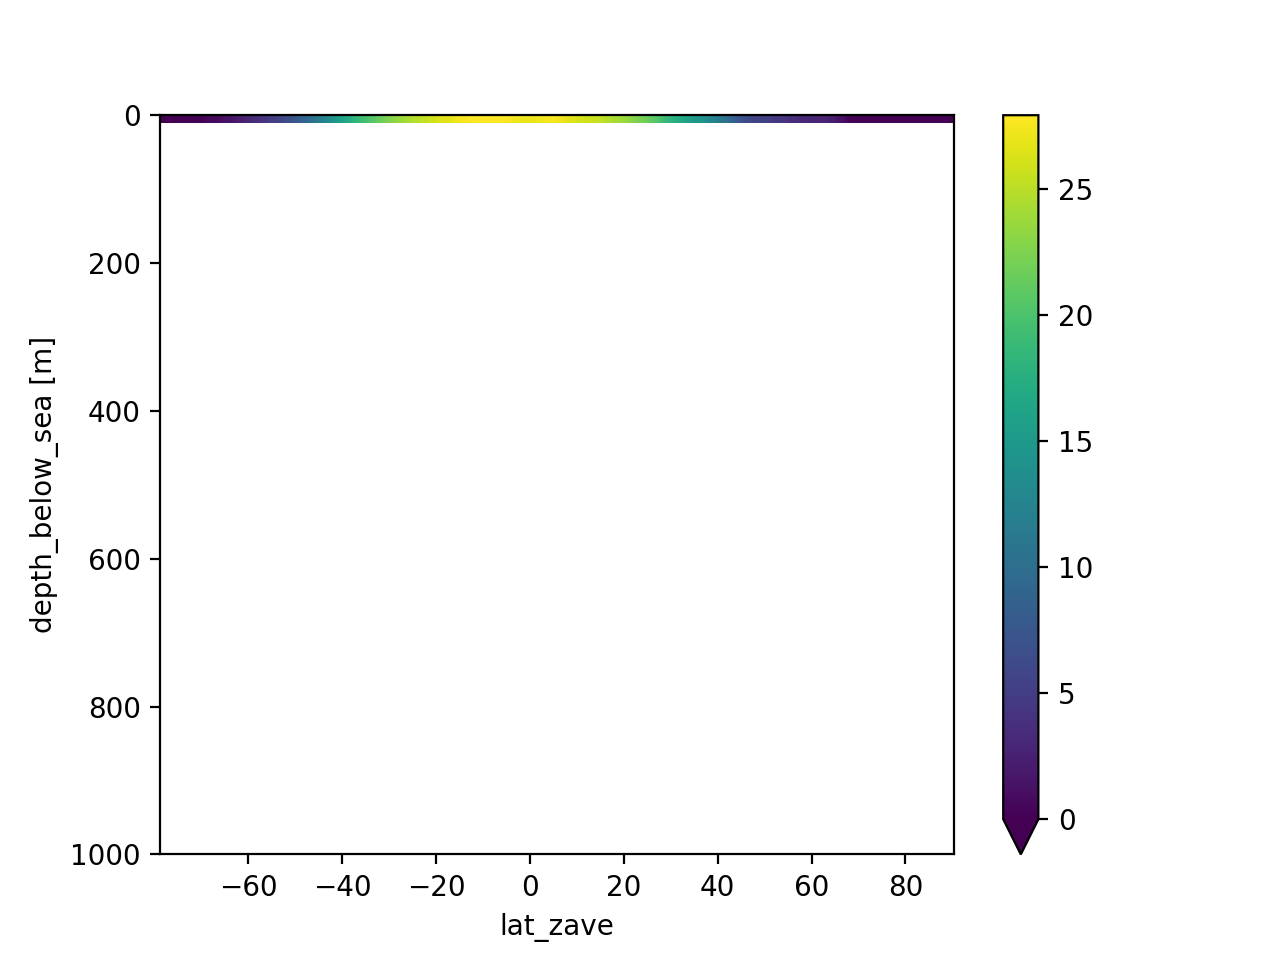

(1000.0, 0.0)

In [99]:
fig = plt.figure()
ax = plt.axes()
# to_zave.where(to_zave!=0.).plot(ax=ax, vmin=0)
to_zave.plot(ax=ax, vmin=0)

ax.set_ylim(1000,0)